In [1]:
import os
import pandas as pd
from glob import glob
from collections import defaultdict

In [2]:
def calculate_stats_per_conv(messages):
    # Remove the initial message (prompt)
    assert messages[0]["role"] == "user"
    messages = messages[1:]
    try:
        # If last message is "assistant", "Answer" -> Add one user message
        if messages[-1]["role"] == "assistant" and "Answer" in messages[-1]["content"]:
            messages += [{"role": "user", "content": "Success"}]
        assert messages[-1]["role"] == "user", f"Last message is not user: {messages[-1]}"
        user_messages_content = [
            m["content"] for m in messages if m["role"] == "user"
        ]
        n_turns = len(user_messages_content)
        # Syntax Incorrect (Initial Action/Answer:): "Invalid generation. "
        n_syntax_incorrect_keywords = sum([
            "Invalid generation." in m for m in user_messages_content
        ])
        # Syntax Incorrect (Issue with tool-call): "Invalid action. "
        n_syntax_incorrect_tool_calls = sum([
            "Invalid action." in m for m in user_messages_content
        ])
        # Calculate Partial Syntax Correct : "*Extra reminder: " in "user" content
        n_partial_syntax_correct = sum([
            "*Extra reminder:" in m for m in user_messages_content
        ])

        return {
            "n_turns": n_turns,
            "n_syntax_incorrect_keywords": n_syntax_incorrect_keywords,
            "n_syntax_incorrect_tool_calls": n_syntax_incorrect_tool_calls,
            "n_partial_syntax_correct": n_partial_syntax_correct
        }
    except Exception as e:
        print(messages)
        raise e


def analyze_dir(dir_names, prefix):
    model_to_df = defaultdict(list)

    for dir_name in dir_names:
        dir_name = prefix + dir_name
        model_dirs = os.listdir(dir_name)
        model_dirs = [d for d in model_dirs if os.path.isdir(os.path.join(dir_name, d))]

        for model_name in model_dirs:
            # print(model_name)
            try:
                text_as_action_df = pd.read_json(os.path.join(dir_name, model_name, 'text_as_action.json'), lines=True)
                json_as_action_df = pd.read_json(os.path.join(dir_name, model_name, 'json_as_action.json'), lines=True)
                code_as_action_df = pd.read_json(os.path.join(dir_name, model_name, 'code_as_action.json'), lines=True)
            except:
                print(f"**Skipping {model_name} since it doesn't have all the files")
                continue

            df = pd.concat([text_as_action_df, json_as_action_df, code_as_action_df])

            if "messages" not in df.columns:
                print(f"**Skipping {model_name} since it doesn't have messages")
                print(df)
                continue
            try:
                conv_stats = df["messages"].apply(calculate_stats_per_conv).apply(pd.Series).rename(
                    columns={"n_turns": "n_turns_conv"}
                )
            except Exception as e:
                print(model_name, dir_name)
                raise e
            # merge the stats
            df = pd.concat([df, conv_stats], axis=1)
            assert (df["n_turns_conv"] == df["n_turns"]).all()
            df = df.drop(columns=["n_turns_conv"])
            model_to_df[model_name].append(df)

    model_stats = []
    output_df = []
    # Concatenate all the dataframes
    for model_name, dfs in model_to_df.items():
        df = pd.concat(dfs)
        _grouped = df.groupby(["is_single_tool_task", "action_mode"])
        df["model_name"] = model_name
        output_df.append(df)

        stats = pd.concat([
                _grouped["n_turns"].agg(["mean", "count", "sum"]).rename(
                    columns={"mean": "avg_turns", "count": "n_tasks", "sum": "n_total_turns"}
                ),
                _grouped["is_correct"].mean().to_frame(),
                _grouped[["n_syntax_incorrect_keywords", "n_syntax_incorrect_tool_calls", "n_partial_syntax_correct"]].sum()
            ],
            axis=1
        )
        stats["model_name"] = model_name
        stats = stats.reset_index().set_index([
            "is_single_tool_task", "model_name", "action_mode"
        ]).sort_index()
        stats["pct_syntax_incorrect_keywords"] = stats["n_syntax_incorrect_keywords"] / stats["n_total_turns"]
        stats["pct_syntax_incorrect_tool_calls"] = stats["n_syntax_incorrect_tool_calls"] / stats["n_total_turns"]
        stats["pct_partial_syntax_correct"] = stats["n_partial_syntax_correct"] / stats["n_total_turns"]
        stats["pct_syntax_correct"] = 1 - stats["pct_syntax_incorrect_keywords"] - stats["pct_syntax_incorrect_tool_calls"] - stats["pct_partial_syntax_correct"]
        stats = stats[[
            "n_tasks", "avg_turns", "is_correct",
            "pct_syntax_incorrect_keywords", "pct_syntax_incorrect_tool_calls", "pct_partial_syntax_correct", "pct_syntax_correct"
        ]].rename(columns={
            "is_correct": "Correct %",
            "pct_syntax_incorrect_keywords": "Syntax Incorrect (Initial Action/Answer) %",
            "pct_syntax_incorrect_tool_calls": "Syntax Incorrect (Issue with tool-call) %",
            "pct_partial_syntax_correct": "Partial Syntax Correct %",
            "pct_syntax_correct": "Syntax Correct %"
        })

        model_stats.append(stats)

    stats = pd.concat(model_stats)
    stats["avg_turns"] = stats["avg_turns"].round(1)
    stats["Correct %"] = stats["Correct %"].round(3)
    display(stats[["avg_turns", "Correct %", "n_tasks"]]\
            .sort_index()\
            .style.format({
                "avg_turns": "{:.1f}",
                "n_tasks": "{:.0f}",
                "Correct %": "{:.1%}"
            })\
            .background_gradient(cmap='Blues', subset=["avg_turns", "Correct %", "n_tasks"]))

    output_df = pd.concat(output_df)
    return stats, output_df


In [3]:
stats, output_df = analyze_dir([
    'travel_itinerary_planning',
    'dna_sequencer',
    'message_decoder',
    'trade_calculator',
    'web_browsing'
    ], 
    prefix="outputs/"
    # prefix="outputs.old.v4.before-contain-word/"
    # prefix="outputs.old.v5.with-thought/"
)
stats = stats.reset_index()

In [4]:
_viz_latex = stats.reset_index()
assert _viz_latex["n_tasks"].nunique() == 1
assert _viz_latex["is_single_tool_task"].nunique() == 1
_viz_latex["Correct %"] = (_viz_latex["Correct %"] * 100).round(2)
_viz_latex["model_name"] = _viz_latex["model_name"].apply(lambda x: f"\\texttt{{{x}}}")
def _process_row(row, lower_better=False, formatter="{:.2f}"):
    sorted_values = sorted(row, reverse=True)
    if lower_better:
        sorted_values = sorted(row)
    max_value = sorted_values[0]
    second_max_value = sorted_values[1]
    
    def _format_value(value):
        formatted_value = formatter.format(value)
        if value == max_value:
            return '$\\mathbf{' + str(formatted_value) + '}$'
        elif value == second_max_value:
            return '\\underline{$' + str(formatted_value) + '$}'
        else:
            return "$" + str(formatted_value) + "$"
    row = row.apply(_format_value)
    return row

_viz_latex = _viz_latex.set_index(["model_name", "action_mode"])[['avg_turns', 'Correct %']].unstack()

# display(_viz_latex)
# find the argmax for correct %

argmax_correct = _viz_latex["Correct %"].idxmax(axis=1)
max_mode_count = argmax_correct.value_counts()
arg_lowest_turns = _viz_latex["avg_turns"].idxmin(axis=1)
lowest_turns_mode_count = arg_lowest_turns.value_counts()
# combine the two
_combined_stats = pd.concat(
    [max_mode_count, lowest_turns_mode_count], axis=1, keys=["Mode with highest correct %", "Mode with lowest turns"])
_combined_stats = _combined_stats.unstack().to_frame().T
display(_combined_stats)
_combined_stats["Mode with highest correct %"] = _combined_stats["Mode with highest correct %"].apply(_process_row, axis=1, formatter="{:d}")
_combined_stats["Mode with lowest turns"] = _combined_stats["Mode with lowest turns"].apply(_process_row, axis=1, formatter="{:d}")
print(_combined_stats.to_latex(escape=False))


print("=============")
_viz_latex["Correct %"] = _viz_latex["Correct %"].apply(_process_row, axis=1)
_viz_latex["avg_turns"] = _viz_latex["avg_turns"].apply(_process_row, axis=1, lower_better=True)
_viz_latex = _viz_latex.rename(
    columns={
        "avg_turns": "2Avg. Turns",
        "Correct %": "1Correct %"
    }
).sort_index(axis=1)
# _viz_latex = _viz_latex.swaplevel(axis=1).sort_index(axis=1)
print(_viz_latex.to_latex(escape=False))


Mode with highest correct %                                \
               code_as_action json_as_action text_as_action   
0                          12              4              2   

  Mode with lowest turns                                
          code_as_action json_as_action text_as_action  
0                     13              3              2

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{3}{l}{Mode with highest correct %} & \multicolumn{3}{l}{Mode with lowest turns} \\
{} &              code_as_action &   json_as_action & text_as_action &         code_as_action &   json_as_action & text_as_action \\
\midrule
0 &               $\mathbf{12}$ &  \underline{$4$} &            $2$ &          $\mathbf{13}$ &  \underline{$3$} &            $2$ \\
\bottomrule
\end{tabular}

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{3}{l}{1Correct %} & \multicolumn{3}{l}{2Avg. Turns} \\
action_mode &       code_as_action &       json_as_action &       text_as_action &      code_as_action &       json_as_action &       text_as_action \\
model_name                         &                      &                      &                      &                     &                      &                      \\
\midrule
\texttt{CodeLlama-13b-Instruct-hf} &      $\mathbf{4.90}$ &      $\mathbf{4.90}$ &      $\mathbf{4.90}$ &  \underline{$9.

/tmp/ipykernel_1891771/1154700701.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(_combined_stats.to_latex(escape=False))
/tmp/ipykernel_1891771/1154700701.py:53: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(_viz_latex.to_latex(escape=False))


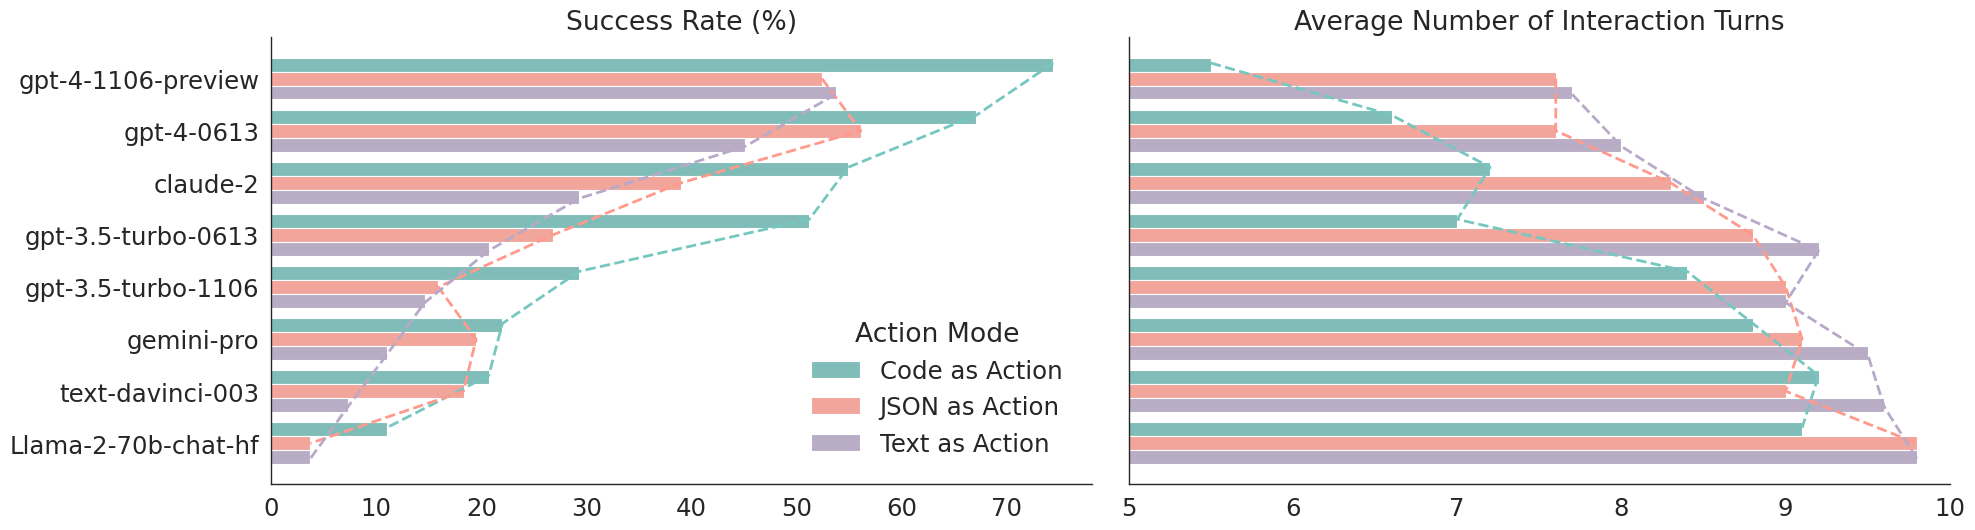

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

_viz_df = stats.query("n_tasks == 82 and is_single_tool_task == False")
_viz_df = _viz_df.reset_index().drop(columns=["is_single_tool_task"]).set_index(["model_name", "action_mode"])
_viz_df["Correct %"] = _viz_df["Correct %"] * 100

def visualize_model_performance_seaborn(dataframe, fig_height=6):
    # Check for required columns
    required_columns = {'model_name', 'action_mode', 'avg_turns', 'Correct %'}
    if not required_columns.issubset(dataframe.columns):
        raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

    # Sorting the DataFrame
    sorted_models = dataframe[
        dataframe['action_mode'] == 'code_as_action'
    ].sort_values(by='Correct %', ascending=False)['model_name'].unique()
    dataframe['model_rank'] = dataframe['model_name'].apply(lambda x: np.where(sorted_models == x)[0][0])

    # rename action model for visualization
    dataframe["action_mode"] = dataframe["action_mode"].replace({
        "code_as_action": "Code as Action",
        "json_as_action": "JSON as Action",
        "text_as_action": "Text as Action"
    })

    # Custom color palette
    custom_palette = {
        # 'code_as_action': '#76c7c0',  # Soft teal/turquoise
        # 'json_as_action': '#ff9a8d',  # Muted coral/salmon
        # 'text_as_action': '#b8a9c9'   # Light lavender/lilac
        'Code as Action': '#76c7c0',  # Soft teal/turquoise
        'JSON as Action': '#ff9a8d',  # Muted coral/salmon
        'Text as Action': '#b8a9c9'   # Light lavender/lilac
    }

    # Melt the DataFrame for seaborn compatibility
    df_melted = dataframe.melt(id_vars=['model_name', 'model_rank', 'action_mode'], 
                               value_vars=['Correct %', 'avg_turns'],
                               var_name='metric', value_name='value')

    # Create a FacetGrid for different metrics
    g = sns.FacetGrid(df_melted, col='metric', sharex=False, height=fig_height, aspect=1.5)
    
    # Map the barplot with the custom palette
    g = g.map_dataframe(sns.barplot, x='value', y='model_rank', hue='action_mode', orient='h', palette=custom_palette)

    # Drawing lines considering the offset
    action_modes = dataframe['action_mode'].unique()
    n_modes = len(action_modes)
    bar_width = 0.2
    offsets = np.linspace(-bar_width*n_modes/2, bar_width*n_modes/2, n_modes)

    for ax, metric in zip(g.axes.flat, ['Correct %', 'avg_turns']):
        for offset, action_mode in zip(offsets, action_modes):
            subset = df_melted[(df_melted['action_mode'] == action_mode) & (df_melted['metric'] == metric)]
            subset = subset.sort_values('model_rank')
            ax.plot(
                subset['value'],
                subset['model_rank'] + offset,
                linestyle='dashed',
                color=custom_palette[action_mode],
                linewidth=2
            )


    # Adjust the legend and axis
    for ax, title in zip(g.axes.flat, ['Success Rate (%)', 'Average Number of Interaction Turns']):
        ax.set_title(title)
        # ax.set_xlabel('Average Number of Interaction Turns' if title == 'Average Interaction Turns' else 'Success Rate (%)')
        ax.set_xlabel("")
        ax.set_yticks(range(len(sorted_models)))
        ax.set_yticklabels(sorted_models)

    # Set the x-axis range for the 'Average Interaction Turns' plot
    g.axes.flat[1].set_xlim(5, 10)  # Adjust as needed
    # remove y-axis label
    g.axes.flat[0].set_ylabel('')
    # Adjust layout and place legend at the bottom
    g.add_legend(title='Action Mode', loc='center', ncol=1, bbox_to_anchor=(0.37, 0.32))
    return g

# sns.set(font="Roboto")
# sns.set_style({'font.family': 'Roboto Mono'})

_selected_models = [
    "gpt-4-1106-preview",
    "gpt-4-0613",
    "claude-2",
    "gpt-3.5-turbo-0613",
    "gpt-3.5-turbo-1106",
    "gemini-pro",
    "text-davinci-003",
    "Llama-2-70b-chat-hf"
]

with sns.axes_style("white"), sns.plotting_context("paper", font_scale=2):
    _fig = visualize_model_performance_seaborn(
        _viz_df.reset_index().set_index("model_name").loc[_selected_models].reset_index(),
        fig_height=6
    )
# _fig.savefig("plots/zeroshot_act_model_performance.pdf", bbox_inches='tight')